In [1]:
!pip install torchviz -q
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  

# Pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


from tqdm.notebook import tqdm

/kaggle/input/tabular-playground-series-jun-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jun-2021/train.csv
/kaggle/input/tabular-playground-series-jun-2021/test.csv


In [2]:
import random
random.seed(0)

In [3]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2021/train.csv", index_col = 'id')
test = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2021/test.csv", index_col = 'id')
TARGET = 'target'
RANDOM_STATE = 42

In [4]:
train = train[~train.drop('target', axis = 1).duplicated()]
train.shape

(199776, 76)

In [5]:
X = pd.DataFrame(train.drop("target", axis = 1))

lencoder = LabelEncoder()
y = pd.DataFrame(lencoder.fit_transform(train['target']), columns=['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

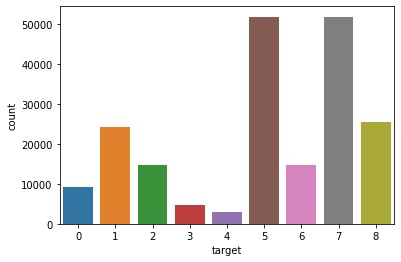

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state= RANDOM_STATE)

sns.countplot(x = TARGET, data= y)

In [7]:
# NN likes numbers from 0-1 .... so we scale our dataset 
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [8]:
X_train, y_train = np.array(X_train, dtype= np.float32), y_train['target'].values 
X_valid, y_valid = np.array(X_valid, dtype= np.float32), y_valid['target'].values

In [9]:
display(X_train)
display(X_valid)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03921569, 0.        , ..., 0.04918033, 0.06153846,
        0.        ],
       [0.        , 0.01960784, 0.03125   , ..., 0.09836066, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03278688, 0.        ,
        0.        ],
       [0.        , 0.01960784, 0.        , ..., 0.01639344, 0.50769234,
        0.        ],
       [0.        , 0.01960784, 0.125     , ..., 0.        , 0.        ,
        0.01923077]], dtype=float32)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.15686275, 0.        , ..., 0.01639344, 0.        ,
        0.        ],
       [0.        , 0.        , 0.015625  , ..., 0.        , 0.00769231,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00769231,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01960784, 0.        , ..., 0.01639344, 0.05384615,
        0.03846154]], dtype=float32)

In [10]:
# Here we will define all params for rest of notebook

BATCH_SIZE = 128
NUM_FEATURES = len(train.columns)-1
NUM_CLASSES = 9
NUM_EPOCHS = 100

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
# Here we will define all params for rest of notebook

class TPS05Dataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

# As you can see we define torch arrays - then we will put them into device
train_dataset = TPS05Dataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
valid_dataset = TPS05Dataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).long())

In [13]:
# Data loaders 
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=1)

In [14]:
dataiter = iter(train_loader)
train_features, train_labels = dataiter.next()
print('Batch #1')
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print("First row from batch #1")
print(train_features[1])

# take next batch (another way)
train_features, train_labels = dataiter.next()
print('\nBatch #2')
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print("First row from batch #2")
print(train_features[1])

Batch #1
Feature batch shape: torch.Size([128, 75])
Labels batch shape: torch.Size([128])
First row from batch #1
tensor([0.0000, 0.0392, 0.0000, 0.0143, 0.0000, 0.0921, 0.0930, 0.0000, 0.0263,
        0.0139, 0.7879, 0.0000, 0.0270, 0.0000, 0.0625, 0.0000, 0.1481, 0.0000,
        0.0455, 0.3042, 0.0333, 0.0000, 0.0000, 0.0455, 0.0725, 0.0000, 0.0000,
        0.0119, 0.0000, 0.0000, 0.0000, 0.0513, 0.1282, 0.0732, 0.0278, 0.0000,
        0.0000, 0.0294, 0.0000, 0.1837, 0.0123, 0.0000, 0.0189, 0.2698, 0.0370,
        0.0333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0714, 0.0000, 0.0000, 0.0000,
        0.0192, 0.0000, 0.1087, 0.0000, 0.0000, 0.0000, 0.0346, 0.0125, 0.0588,
        0.0125, 0.0400, 0.0000, 0.1667, 0.0633, 0.0182, 0.0000, 0.0149, 0.0000,
        0.0492, 0.0615, 0.0000])

Batch #2
Feature batch shape: torch.Size([128, 75])
Labels batch shape: torch.Size([128])
First row from batch #2
tensor([0.0000, 0.0000, 0.0938, 0.0857, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.

In [15]:
class TPS05ClassificationModule(nn.Module):
    def __init__(self, num_feature, num_class):
        super(TPS05ClassificationModule, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_4 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, num_class)
        
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.2)
        
        self.batchnorm_1 = nn.BatchNorm1d(128)
        self.batchnorm_2 = nn.BatchNorm1d(64)
        self.batchnorm_3 = nn.BatchNorm1d(32) 
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, x):
        x = self.layer_1(x)        
        x = F.relu(x)   # Second one using torch.nn.functional
        x = self.dropout_1(x)
        
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.batchnorm_1(x)
        x = self.dropout_1(x)
        
        x = self.layer_3(x)
        x = self.batchnorm_2(x)
        x = self.relu(x)
        x = self.dropout_1(x)
        
        x = self.layer_4(x)
        x = self.batchnorm_3(x) 
        x = self.softmax(x)        
        x = self.dropout_1(x)
        
        x = self.layer_out(x)   

        
        return x
    

In [16]:
modelMod = TPS05ClassificationModule(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
# Then pushi it to device (CPU/GPU)

# model.eval() is switch off for some specific layers/parts of the model (Dropouts Layers, BatchNorm Layers etc.) 
modelMod.eval()

# Whenever you want you can print model 
print(modelMod)

TPS05ClassificationModule(
  (layer_1): Linear(in_features=75, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=9, bias=True)
  (dropout_1): Dropout(p=0.3, inplace=False)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (batchnorm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
model = modelMod

In [19]:
Learning_Rate = 0.001
optimizer = optim.Adam(model.parameters(),lr=Learning_Rate)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer,'min',factor = 0.5,patience = 2,cooldown = 0,verbose = 1)

In [20]:
class EarlyStoppingCallback:   
    def __init__(self, min_delta = 0.0000001, patience = 20,restore_best_weights=True):
        
        self.min_delta = min_delta
        self.patience = patience
        self.restore_best_weights = True
        self.best_epoch_score = 0
        
        self.attempt = 0
        self.best_score = None
        self.stop_training = False
        
        
    def __call__(self, validation_loss):

        self.epoch_score = validation_loss

        if self.best_epoch_score == 0:
            self.best_epoch_score = self.epoch_score
        elif self.epoch_score > self.best_epoch_score - self.min_delta:
            self.attempt += 1
            print(f'Message from callback (Early Stopping) counter: {self.attempt}/{self.patience}')
            if self.attempt >= self.patience:
                self.stop_training = True
        else:
            self.best_epoch_score = self.epoch_score
            self.attempt = 0

In [21]:
accuracy_stat = {'train': [],"validation": []}
loss_stat = {'train': [], "validation": [] }

def acc_calc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [22]:
def train_nn():
    for progress in tqdm(range(1, NUM_EPOCHS+1)):

        train_epoch_loss = 0
        train_epoch_acc = 0

        model.train()

        # We loop over training dataset using batches (we use DataLoader to load data with batches)
        for X_train_batch, y_train_batch in train_loader:
            

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass ->>>>
            y_train_pred = model(X_train_batch)

            # Find Loss and backpropagation of gradients
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = acc_calc(y_train_pred, y_train_batch)

            # backward <------    
            train_loss.backward()

            # Update the parameters (weights and biases)
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()


        #  Then we validate our model - concept is the same
        with torch.no_grad():

            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for X_val_batch, y_val_batch in valid_loader:
               

                y_val_pred = model(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = acc_calc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        # end of validation loop
        early_stopping_callback(val_epoch_loss/len(valid_loader))
        if early_stopping_callback.stop_training:
            print(f'Training stopped -> Early Stopping Callback : validation_loss: {val_epoch_loss/len(valid_loader)}')
            break

        loss_stat['train'].append(train_epoch_loss/len(train_loader))
        loss_stat['validation'].append(val_epoch_loss/len(valid_loader))
        accuracy_stat['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stat['validation'].append(val_epoch_acc/len(valid_loader))                           
        
        
        # 2021.05.17 
        # This is a part of NN optimization
        clr = optimizer.param_groups[0]['lr']        
        scheduler.step(val_epoch_acc/len(valid_loader))

        print(f'Epoch { progress + 0:03}: Loss: [Train: {train_epoch_loss/len(train_loader):.5f} | Validation: {val_epoch_loss/len(valid_loader):.5f} ] Accuracy: [Train: {train_epoch_acc/len(train_loader):.3f} | Validation: {val_epoch_acc/len(valid_loader):.3f}] LR: {clr}')

In [23]:
early_stopping_callback = EarlyStoppingCallback(0.0000001, 20)

train_nn()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: Loss: [Train: 1.88707 | Validation: 1.80102 ] Accuracy: [Train: 31.673 | Validation: 34.751] LR: 0.001
Epoch 002: Loss: [Train: 1.80491 | Validation: 1.78086 ] Accuracy: [Train: 34.223 | Validation: 35.356] LR: 0.001
Epoch 003: Loss: [Train: 1.79246 | Validation: 1.77483 ] Accuracy: [Train: 34.614 | Validation: 35.284] LR: 0.001
Epoch     4: reducing learning rate of group 0 to 5.0000e-04.
Epoch 004: Loss: [Train: 1.78526 | Validation: 1.77130 ] Accuracy: [Train: 34.885 | Validation: 35.324] LR: 0.001
Epoch 005: Loss: [Train: 1.77826 | Validation: 1.76780 ] Accuracy: [Train: 35.195 | Validation: 35.477] LR: 0.0005
Epoch 006: Loss: [Train: 1.77524 | Validation: 1.76682 ] Accuracy: [Train: 35.377 | Validation: 35.499] LR: 0.0005
Epoch     7: reducing learning rate of group 0 to 2.5000e-04.
Epoch 007: Loss: [Train: 1.77266 | Validation: 1.76624 ] Accuracy: [Train: 35.460 | Validation: 35.489] LR: 0.0005
Epoch 008: Loss: [Train: 1.76839 | Validation: 1.76511 ] Accuracy: [Train: 

In [24]:
df_train_va = pd.DataFrame.from_dict(accuracy_stat).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
df_train_vl = pd.DataFrame.from_dict(loss_stat).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

Text(0.5, 1.0, 'Train - Validation Loss/Epoch')

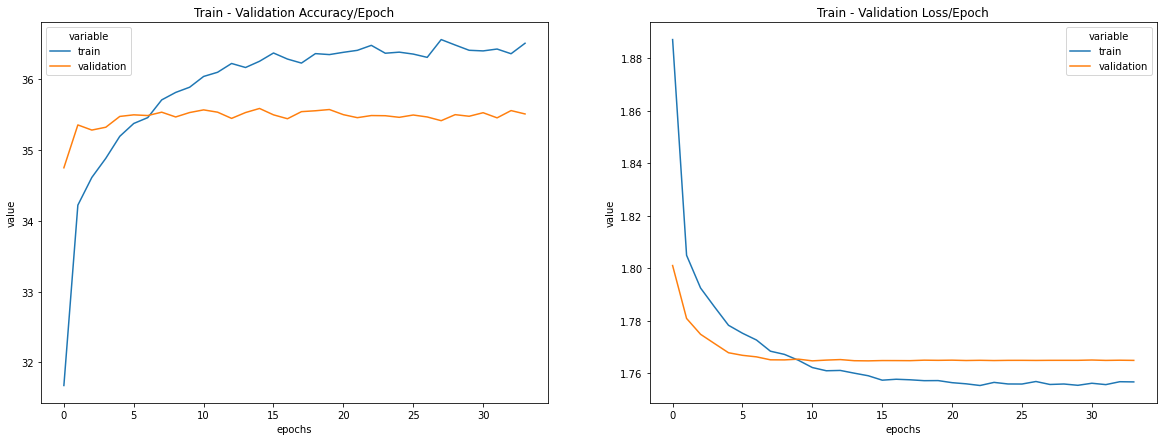

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data = df_train_va, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train - Validation Accuracy/Epoch')
sns.lineplot(data = df_train_vl, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train - Validation Loss/Epoch')

In [26]:
tensor_preds = model(torch.from_numpy(scaler.transform(test)).float())
tensor_preds[0]

tensor([-0.3530,  1.4694,  0.5805, -1.1340, -1.8081,  0.3773, -1.0785, -0.2959,
         0.4081], grad_fn=<SelectBackward>)

In [27]:
nn_preds = torch.nn.functional.softmax(tensor_preds, dim=1).detach().numpy() 
nn_preds[0]

array([0.06180502, 0.38234693, 0.15718967, 0.02830217, 0.01442316,
       0.12828737, 0.02991777, 0.06543312, 0.1322949 ], dtype=float32)

In [28]:
sub = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2021/sample_submission.csv")
predictions_df = pd.DataFrame(nn_preds, columns = ["Class_1", "Class_2", "Class_3","Class_4","Class_5","Class_6","Class_7","Class_8","Class_9"])
predictions_df['id'] = sub['id']

In [29]:
predictions_df.head(5)

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,id
0,0.061805,0.382347,0.157190,0.028302,0.014423,0.128287,0.029918,0.065433,0.132295,200000
1,0.047472,0.066258,0.052751,0.023224,0.016457,0.245400,0.091056,0.327116,0.130265,200001
2,0.022788,0.028629,0.022327,0.010592,0.007482,0.638704,0.040559,0.171579,0.057342,200002
3,0.045469,0.075015,0.057493,0.023684,0.016060,0.316280,0.077526,0.260739,0.127733,200003
4,0.048986,0.112766,0.080009,0.027437,0.017367,0.256097,0.075841,0.231500,0.149997,200004


In [30]:
predictions_df.drop("id", axis=1).describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Class_1,100000.000000,0.046034,0.009351,0.011760,0.042336,0.048343,0.051386,0.064148
Class_2,100000.000000,0.122205,0.102250,0.017901,0.040777,0.084781,0.172868,0.420194
Class_3,100000.000000,0.075051,0.044683,0.012938,0.035569,0.063697,0.109285,0.170285
Class_4,100000.000000,0.023871,0.006390,0.006112,0.019240,0.025639,0.029269,0.032515
Class_5,100000.000000,0.015437,0.003051,0.003943,0.014426,0.016289,0.017420,0.024009
Class_6,100000.000000,0.255712,0.147322,0.044076,0.157734,0.237901,0.306176,0.822735
Class_7,100000.000000,0.074312,0.023110,0.018563,0.058004,0.078812,0.093038,0.115109
Class_8,100000.000000,0.257653,0.104958,0.058365,0.168839,0.268709,0.352722,0.449016
Class_9,100000.000000,0.129725,0.033498,0.028144,0.107179,0.135174,0.156599,0.183208


In [31]:
predictions_df.to_csv("submission.csv", index = False)

In [32]:
predictions_df

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,id
0,0.061805,0.382347,0.157190,0.028302,0.014423,0.128287,0.029918,0.065433,0.132295,200000
1,0.047472,0.066258,0.052751,0.023224,0.016457,0.245400,0.091056,0.327116,0.130265,200001
2,0.022788,0.028629,0.022327,0.010592,0.007482,0.638704,0.040559,0.171579,0.057342,200002
3,0.045469,0.075015,0.057493,0.023684,0.016060,0.316280,0.077526,0.260739,0.127733,200003
4,0.048986,0.112766,0.080009,0.027437,0.017367,0.256097,0.075841,0.231500,0.149997,200004
...,...,...,...,...,...,...,...,...,...,...
99995,0.060589,0.373220,0.161780,0.029622,0.015159,0.104258,0.034952,0.078507,0.141913,299995
99996,0.050895,0.201873,0.120443,0.031011,0.017003,0.204267,0.057390,0.152470,0.164648,299996
99997,0.055442,0.299334,0.148768,0.031348,0.016225,0.146336,0.042906,0.103604,0.156037,299997
99998,0.031817,0.028574,0.025231,0.013652,0.010613,0.448477,0.067901,0.294497,0.079237,299998
